
__References:__ 

[Faster R-CNN (object detection) implemented by Keras for custom data from Google’s Open Images Dataset V4](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras

# Install Libs

In [11]:
!pip install --upgrade pyDSlib
!pip install wget
import IPython
IPython.display.clear_output()

# Import Libs

In [1]:
import tensorflow as tf
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wget
import skimage
import cv2
import joblib
import gc

In [3]:
gc.collect()

20

In [4]:
sys.path.insert(0, '/mr3_boltprod_john_t_leonard/Data_Science_Projects./ObjDetection/pyDSlib/')

In [5]:
import pyDSlib as DS
DS.__version__

pycocotools is not installed. To use pretrained mask-RCNN on coco, run $pip install pycocotools


'0.3.5'

# Define Paths

In [7]:
root_dir = os.path.abspath('../../../')
data_dir = os.path.join(root_dir, 'ObjDetection_Data')
outputs_dir = os.path.join(root_dir,'outputs')

for dir_ in [data_dir, outputs_dir]:
    if not os.path.isdir(dir_):
        os.makedirs(dir_)

# Fetch Dataset

We'll use google's open images dataset. This dataset contains 600 classes. We'll pull the meta data for everything, then only pull the images for a single class.

__References:__

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

## Fetch Meta Data

In [8]:
data_dir = os.path.join(data_dir,'open_images_v5')
imgs_dir = os.path.join(data_dir, 'imgs')

for dir_ in [data_dir, imgs_dir]:
    if not os.path.isdir(dir_):
        os.makedirs(dir_)

In [9]:
downloads = {'class-descriptions-boxable.csv':'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv',
             'train-annotations-bbox.csv': 'https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-annotations-bbox.csv',
             'train-images-boxable.csv': 'https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv'}

In [10]:
for key in downloads.keys():
    file = os.path.join(data_dir, key)
    if not os.path.isfile(file):
        wget.download(downloads[key], file)

In [11]:
os.listdir(data_dir)

['train-images-boxable.csv',
 'imgs',
 'train-annotations-bbox.csv',
 '.ipynb_checkpoints',
 'class-descriptions-boxable.csv']

In [12]:
class_descriptions = pd.read_csv(os.path.join(data_dir, 'class-descriptions-boxable.csv'),
                                 header = None)
class_descriptions.columns = ['LabelName', 'class']
imgs_boxable = pd.read_csv(os.path.join(data_dir, 'train-images-boxable.csv'))
annotations_bbox = pd.read_csv(os.path.join(data_dir, 'train-annotations-bbox.csv'))

In [13]:
class_descriptions.head()

LabelName       class
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [14]:
imgs_boxable['ImageID'] = imgs_boxable['image_name'].str.split('.',expand=True).iloc[:,0]
imgs_boxable.head()

image_name                                          image_url  \
0  e39871fd9fd74f55.jpg  https://requestor-proxy.figure-eight.com/figur...   
1  f18b91585c4d3f3e.jpg  https://requestor-proxy.figure-eight.com/figur...   
2  ede6e66b2fb59aab.jpg  https://requestor-proxy.figure-eight.com/figur...   
3  ed600d57fcee4f94.jpg  https://requestor-proxy.figure-eight.com/figur...   
4  ff47e649b23f446d.jpg  https://requestor-proxy.figure-eight.com/figur...   

            ImageID  
0  e39871fd9fd74f55  
1  f18b91585c4d3f3e  
2  ede6e66b2fb59aab  
3  ed600d57fcee4f94  
4  ff47e649b23f446d

In [15]:
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [16]:
annotations_bbox.shape

(14610229, 13)

## Merge all meta data

In [17]:
img_meta = pd.merge(annotations_bbox, imgs_boxable, on = 'ImageID')
img_meta = pd.merge(img_meta, class_descriptions, on = 'LabelName')
img_meta.shape

(14610229, 16)

## Initial Image Inspection

In [18]:
def plot_img(ImageID, 
             img_meta,
             tight_layout_rect=(0,0,1,1)):
    """
    show an image and the bounding boxes for that image given an ImageID
    """
    
    # fetch image
    img_name = ImageID+'.jpg'
    img_url = img_meta[img_meta['image_name']==img_name]['image_url'].iloc[0]
    img = skimage.io.imread(img_url)
    height, width, _ = img.shape
    
    #fetch bbox's and annotations
    img_meta = img_meta[img_meta['ImageID']==ImageID]
    
    fig, ax = plt.subplots(1,1)
    
    ax.set_title('ImageID:'+ImageID)
    
    #add bbox's and annotations to img
    for i, slice_ in img_meta.iterrows():
        
        #build box
        xymin = (int(slice_['XMin']*width), 
                 int(slice_['YMin']*height))
        xymax = (int(slice_['XMax']*width), 
                 int(slice_['YMax']*height))
        cv2.rectangle(img, xymin, xymax, (0,255,0), 2)
        
        #build annotation
        label_name = slice_['LabelName']
        class_series = img_meta[img_meta['LabelName']==label_name]
        class_name = class_series['class'].iloc[0]
        cv2.putText(img, class_name, 
                    (xymin[0]+5,xymin[1]+20),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)
    
    #plot img
    ax.imshow(img)
    ax.grid(which='both',visible=False)
    
    fig.tight_layout(rect=tight_layout_rect)
    plt.show()

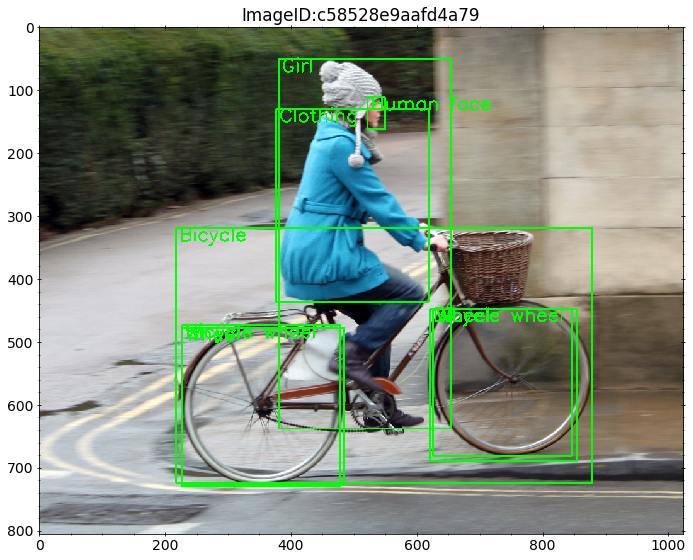

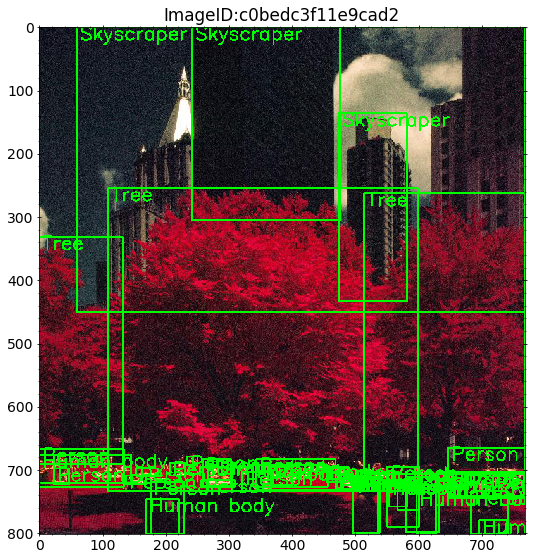

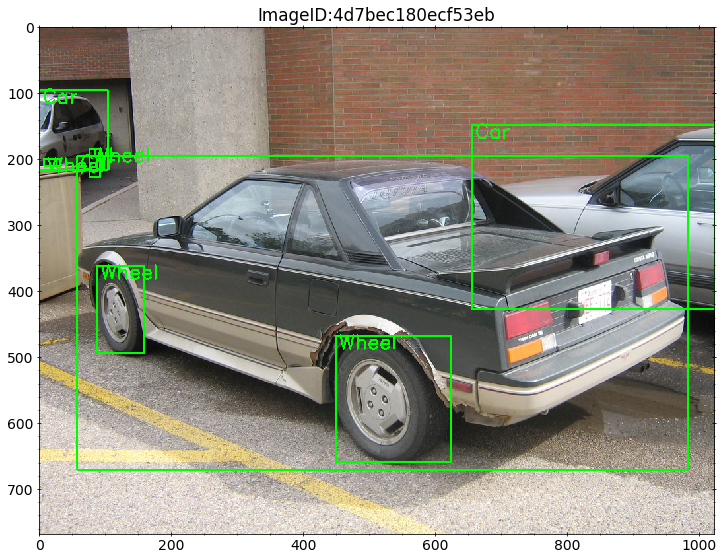

In [19]:
ImageIDs = img_meta['ImageID'].unique()
for i in list(np.random.randint(0,len(ImageIDs)-1, 3)):
    
    ImageID=ImageIDs[i]
    
    plot_img(ImageID, 
         img_meta,
         tight_layout_rect=(0,0,2,2))

# Inspect Classes

In [20]:
classes = sorted(list(img_meta['class'].unique()))
print('n classes', len(classes))
display(classes)

n classes 599


['Accordion',
 'Adhesive tape',
 'Aircraft',
 'Airplane',
 'Alarm clock',
 'Alpaca',
 'Ambulance',
 'Animal',
 'Ant',
 'Antelope',
 'Apple',
 'Armadillo',
 'Artichoke',
 'Auto part',
 'Axe',
 'Backpack',
 'Bagel',
 'Baked goods',
 'Balance beam',
 'Ball',
 'Balloon',
 'Banana',
 'Band-aid',
 'Banjo',
 'Barge',
 'Barrel',
 'Baseball bat',
 'Baseball glove',
 'Bat (Animal)',
 'Bathroom accessory',
 'Bathroom cabinet',
 'Bathtub',
 'Beaker',
 'Bear',
 'Bed',
 'Bee',
 'Beehive',
 'Beer',
 'Beetle',
 'Bell pepper',
 'Belt',
 'Bench',
 'Bicycle',
 'Bicycle helmet',
 'Bicycle wheel',
 'Bidet',
 'Billboard',
 'Billiard table',
 'Binoculars',
 'Bird',
 'Blender',
 'Blue jay',
 'Boat',
 'Bomb',
 'Book',
 'Bookcase',
 'Boot',
 'Bottle',
 'Bottle opener',
 'Bow and arrow',
 'Bowl',
 'Bowling equipment',
 'Box',
 'Boy',
 'Brassiere',
 'Bread',
 'Briefcase',
 'Broccoli',
 'Bronze sculpture',
 'Brown bear',
 'Building',
 'Bull',
 'Burrito',
 'Bus',
 'Bust',
 'Butterfly',
 'Cabbage',
 'Cabinetry',
 'C

# Fetch Subset of Images

Let's just focus on detecting people

In [21]:
classes = ['Backpack', 
           'Balloon', 
           'Ball', 
           'Belt', 
           'Bench',
           'Bicycle helmet', 
           'Bicycle wheel',
           'Bicycle', 
           'Person', 
           'Binoculars', 
           'Bomb', 
           'Boot', 
           'Bottle', 
           'Box', 
           'Briefcase',
           'Cake',
         'Calculator',
         'Camera',
         'Candy',
         'Cart',
         'Chair',
         'Clock',
         'Clothing',
         'Coat',
         'Coin',
         'Computer keyboard',
         'Computer monitor',
         'Computer mouse',
         'Container',
         'Cookie',
         'Corded phone',
         'Couch',
         'Countertop',
         'Cowboy hat',
         'Crown',
         'Dagger',
         'Desk',
         'Digital clock',
         'Dog',
         'Doll',
         'Door',
         'Dress',
         'Drink',
         'Earrings',
         'Envelope',
         'Facial tissue holder',
         'Fashion accessory',
         'Fedora',
         'Flag',
         'Flashlight',
         'Flower',
         'Food',
         'Football',
         'Football helmet',
         'Footwear',
         'Furniture',
         'Girl',
         'Glasses',
         'Glove',
         'Goggles',
         'Guitar',
         'Handbag',
         'Handgun',
         'Hat',
         'Headphones',
         'Helmet',
         'High heels',
         'Hiking equipment',
         'Houseplant',
         'Human arm',
         'Human beard',
         'Human body',
         'Human ear',
         'Human eye',
         'Human face',
         'Human foot',
         'Human hair',
         'Human hand',
         'Human head',
         'Human leg',
         'Human mouth',
         'Human nose',
         'Ipod',
         'Jacket',
         'Knife',
         'Lamp',
         'Laptop',
         'Lavender (Plant)',
         'Light bulb',
         'Light switch',
         'Lipstick',
         'Loveseat',
         'Luggage and bags',
         'Man',
         'Microphone',
         'Musical instrument',
         'Musical keyboard',
         'Necklace',
         'Office supplies',
         'Ostrich',
         'Paper cutter',
         'Paper towel',
         'Pen',
         'Pencil case',
         'Pencil sharpener',
         'Perfume',
         'Person',
         'Personal care',
         'Piano',
         'Picture frame',
         'Plant',
         'Plastic bag',
         'Power plugs and sockets',
         'Printer',
         'Pumpkin',
         'Remote control',
         'Rifle',
         'Roller skates',
         'Rose',
         'Rugby ball',
         'Ruler',
         'Sandal',
         'Scarf',
         'Scissors',
         'Scoreboard',
         'Scorpion',
         'Sculpture',
         'Segway',
         'Serving tray',
         'Sewing machine',
         'Shelf',
         'Shirt',
         'Shorts',
         'Shotgun',
         'Skateboard',
         'Ski',
         'Skirt',
         'Skull',
         'Snack',
         'Sock',
         'Sofa bed',
         'Sombrero',
         'Sports equipment',
         'Sports uniform',
         'Squash (Plant)',
         'Stairs',
         'Stapler',
         'Stool',
         'Street light',
         'Studio couch',
         'Suit',
         'Suitcase',
         'Sun hat',
         'Sunglasses',
         'Swimwear',
         'Sword',
         'Table',
         'Table tennis racket',
         'Tablet computer',
         'Teddy bear',
         'Telephone',
         'Television',
         'Tennis ball',
         'Tennis racket',
         'Tie',
         'Tin can',
         'Toy',
         'Training bench',
         'Tree',
         'Truck',
         'Trumpet',
         'Umbrella',
         'Unicycle',
         'Van',
         'Vase',
         'Vehicle',
         'Violin',
         'Volleyball (Ball)',
         'Wall clock',
         'Wardrobe',
         'Waste container',
         'Watch',
         'Weapon',
         'Wheelchair',
         'Whiteboard',
         'Window',
         'Window blind',
         'Woman',
          ]

img_meta = img_meta[img_meta['class'].isin(classes)]
img_meta.shape

(11794596, 16)

In [22]:
ImageIDs = list(img_meta['ImageID'].unique())
ImageNames = [ImageID + '.jpg' for ImageID in ImageIDs]
print('n images:',len(ImageIDs))

n images: 1378994


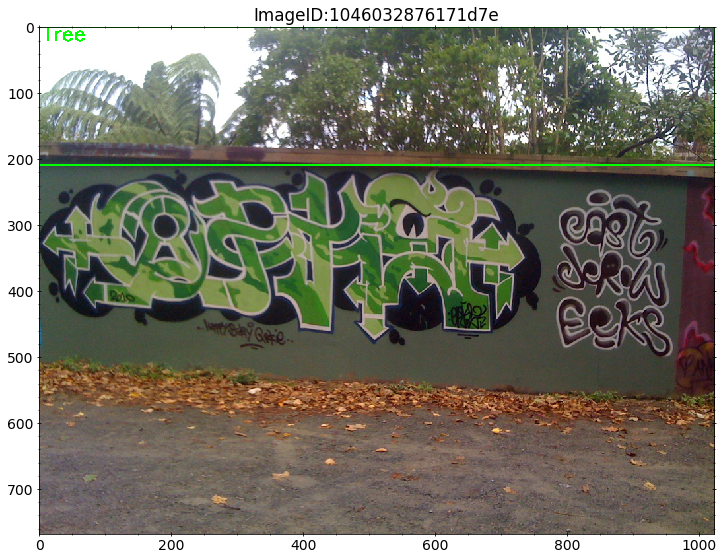

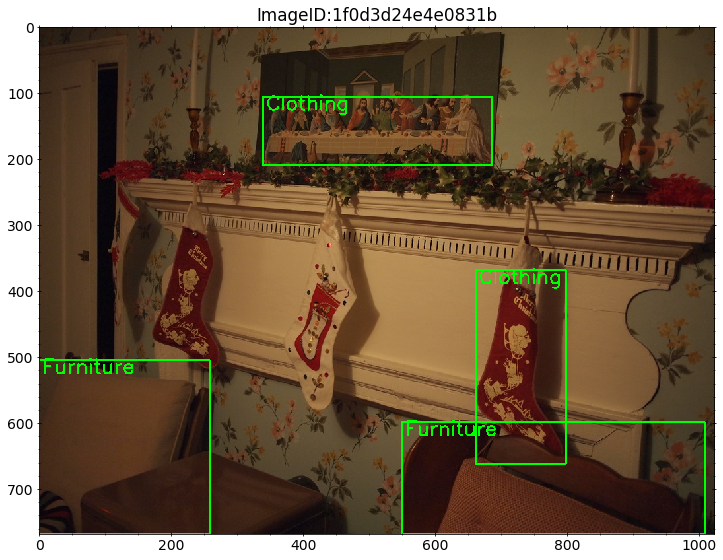

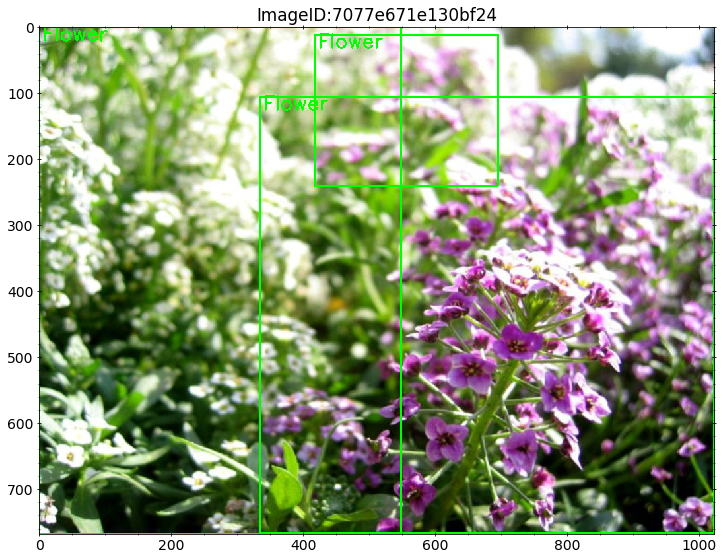

In [23]:
for i in list(np.random.randint(0,len(ImageIDs)-1, 3)):
    
    ImageID=ImageIDs[i]
    
    plot_img(ImageID, 
         img_meta,
         tight_layout_rect=(0,0,2,2))

### Setup Flow From Generator Directories

In [24]:
import sklearn.model_selection

In [25]:
# #slice out subsample
# subsample_size=len(ImageNames)
# ImageNames = ImageNames[0:subsample_size]

In [26]:
#train test split ImageNames
ImageNames_train, ImageNames_test = sklearn.model_selection.train_test_split(
                                                             ImageNames, 
                                                             test_size = 0.2, 
                                                             random_state = 0)

In [27]:
print('n train images:', len(ImageNames_train))
print('n test images:',len(ImageNames_test))

n train images: 1103195
n test images: 275799


In [28]:
img_meta.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside            image_name  \
0         0  000002b66c9c498e.jpg   
1         0  000002b66c9c498e.jpg   
2         0  000002b66c9c498e.jpg   
3         0  000002b66c9c498e.jpg   
4         0  000002b66c9c498e.jpg   

                                           image_url   class  
0  https://requestor-proxy.figure-eight.com/figur...  Person  
1  https://requestor-proxy.figure-eight.com/figur...  Person  
2  https://requestor-proxy.figure-eight.com/figur...  Person  
3  https://requestor-proxy.figure-eight.com/figur...  Person  
4  https://requestor-proxy.figure-eight.com/figur...  Person

In [33]:
def download_img(ImageName, imgs_dir, img_url):
    path_img = os.path.join(imgs_dir, ImageName)

    if not os.path.isfile(path_img):
        wget.download(img_url, path_img)
        
def download_imgs(img_meta, imgs_dir):

    if not os.path.isdir(imgs_dir):
        os.makedirs(imgs_dir)
    
    #Instantiate parallel job   
    print('n Images to download:',len(img_meta['image_name'].unique()))
    executor = joblib.Parallel(n_jobs=-1, verbose = 2, backend='multiprocessing' )
    jobs = [joblib.delayed(download_img)(ImageName, imgs_dir, img_url) for [ImageName, img_url], _ in img_meta.groupby(['image_name','image_url'])]
    outputs = executor(jobs)
    gc.collect()

In [31]:
img_meta = img_meta.sort_values('class')

In [35]:
for [class_, LabelName], img_meta_by_class in img_meta.groupby(['class', 'LabelName']):
    
    print(class_)
    
    img_meta_by_class_train = img_meta_by_class[img_meta_by_class['image_name'].isin(ImageNames_train)]
    img_meta_by_class_test = img_meta_by_class[img_meta_by_class['image_name'].isin(ImageNames_test)]
    
    imgs_dir_train = os.path.join(imgs_dir, 'train', class_)
    imgs_dir_test = os.path.join(imgs_dir, 'test', class_)

    download_imgs(img_meta_by_class_train, imgs_dir_train)
    download_imgs(img_meta_by_class_test, imgs_dir_test)  

Backpack
n Images to download: 550


ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information